In [21]:
import wfdb
import numpy as np
import glob
from scipy import signal,io
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats as set_fmt
set_fmt('svg')         
import warnings  
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Define annotation categories for ECG beat types

In [2]:
table = {
    'N': ['N'],                 # Normal
    'S': ['A', 'a', 'S', 'J'],  # Supraventricular ectopic beats
    'F': ['F'],                 # Fusion of ventricular and normal beat
    'V': ['V'],                 # Ventricular ectopic beats
    'U': ['Q', 'U', '/', 'p']   # Unknown beats
}



# Filter settings

In [23]:
fs = 360  # Sampling frequency
fl = 0.5  # Low cutoff frequency for high-pass filter
fh = 20   # High cutoff frequency for low-pass filter


# Define high-pass and low-pass Butterworth filters
b1, a1 = signal.butter(N=3, Wn=fl / (fs / 2), btype='high')
b2, a2 = signal.butter(N=3, Wn=fh / (fs / 2), btype='low')


# Load list of ECG files

In [24]:
# Load list of ECG files in the specified directory

listNames = glob.glob('mit-bih-arrhythmia-database/*.dat')

# Check if files are found
if not listNames:
    print("No ECG files found in the specified directory.")
else:
    print(f"Processing {len(listNames)} files.")



Processing 48 files.


# Segmentation 

In [8]:
# Initialize lists to store segmented beats by type
data0, data1, data2, data3, data4 = [], [], [], [], []

# Iterate through each ECG file in the directory
for name in listNames:
    # Remove the file extension from the name to get the record name
    recordName = name.partition('.')[0]
    print(f"Processing record: {recordName}")

    # Read ECG signal and metadata
    sig, fields = wfdb.rdsamp(record_name=recordName)  # Corrected argument name
    
    # Apply high-pass and low-pass filters
    sig = signal.filtfilt(b1, a1, sig[:, 0], padtype='even', axis=0)
    sig = signal.filtfilt(b2, a2, sig, padtype='even')
    
    # Read annotations (R-peak positions and beat types)
    annotations = wfdb.rdann(recordName, 'atr')
    pos = annotations.sample  # Sample positions of annotations
    labels = annotations.symbol  # Beat type symbols
    fs = fields['fs']

    # Segment beats based on annotation positions
    for i in range(1, len(pos) - 1):
        indx = list(range(pos[i] - 80, pos[i] + 120))  # Range of samples around R-peak
        qrs = sig[indx]
        type = labels[i]

        # Append the QRS segment to the appropriate list based on beat type
        if type in table['N']:
            data0.append(qrs)
        elif type in table['S']:
            data1.append(qrs)
        elif type in table['F']:
            data2.append(qrs)
        elif type in table['V']:
            data3.append(qrs)
        elif type in table['U']:
            data4.append(qrs)

# Convert lists to NumPy arrays for further processing
data0 = np.array(data0, dtype=np.float64)
data1 = np.array(data1, dtype=np.float64)
data2 = np.array(data2, dtype=np.float64)
data3 = np.array(data3, dtype=np.float64)
data4 = np.array(data4, dtype=np.float64)


print('-'*40)
print('Segmentation is done!')



Processing record: /Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/213
Processing record: /Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/207
Processing record: /Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/212
Processing record: /Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/210
Processing record: /Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/205
Processing record: /Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/201
Processing record: /Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/215
Processing record: /Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/214
Processing record: /Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/200
Processing record: /Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/228
Processing record: /Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/202
Processing record: /Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/203
Processing record: /Users/parisa/Desktop/ECG/mit-bih-arrhythmia-database/217

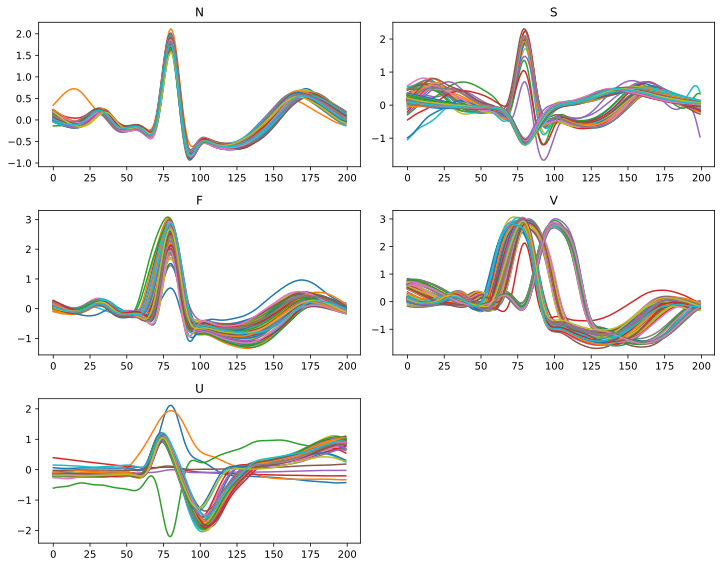

In [9]:
# Plot examples of each beat type

plt.figure(figsize=(10, 8))

plt.subplot(3, 2, 1)
plt.plot(data0[:100, :].T)
plt.title('N')

plt.subplot(3, 2, 2)
plt.plot(data1[:100, :].T)
plt.title('S')

plt.subplot(3, 2, 3)
plt.plot(data2[:100, :].T)
plt.title('F')

plt.subplot(3, 2, 4)
plt.plot(data3[:100, :].T)
plt.title('V')

plt.subplot(3, 2, 5)
plt.plot(data4[:100, :].T)
plt.title('U')

plt.tight_layout()
plt.show()



# Building template 

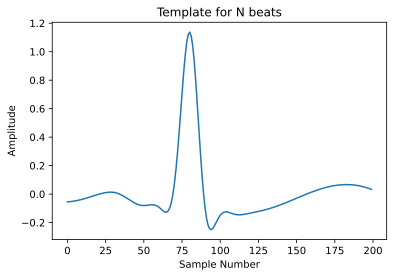

In [25]:
# Calculate and plot the template for normal beats (N)
template1 = np.mean(data0, axis=0)

plt.figure(figsize=(6, 4))
plt.plot(template1)
plt.title('Template for N beats')
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")

plt.show()

In [26]:
# Save the template file

filename = 'Template.mat'
dc = {'N': template1}
io.savemat(file_name=filename, mdict=dc)

print("Template saved to Template.mat")

Template saved to Template.mat


# calculate correlation

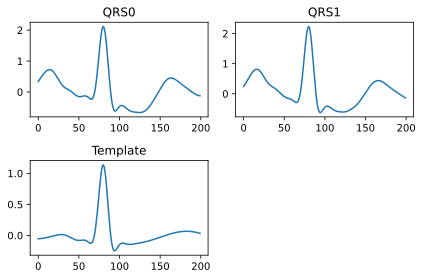

In [27]:
qrs0 = data0[1, :]
qrs1 = data1[1, :]


# Plot 
plt.subplot(2, 2, 1)
plt.plot(qrs0)
plt.title('QRS0')
plt.subplot(2, 2, 2)
plt.plot(qrs1)
plt.title('QRS1')
plt.subplot(2, 2, 3)
plt.plot(template1)
plt.title('Template')
plt.tight_layout()
plt.show()

In [28]:
# Calculate correlation of QRS segments with the template
crr = np.corrcoef(qrs0, template1)
print(f'Maximum correlation with QRS0 is: {crr[0, 1]:.4f}')

crr = np.corrcoef(qrs1, template1)
print(f'Maximum correlation with QRS1 is: {crr[0, 1]:.4f}')


Maximum correlation with QRS0 is: 0.8480
Maximum correlation with QRS1 is: 0.8535


In [29]:
# Correlation of template with multiple QRS segments
crr = np.corrcoef(template1, data0[:5, :])
print(f'Maximum correlation for first 5 beats is: {crr[0, 1:]}')


Maximum correlation for first 5 beats is: [0.84149516 0.84802212 0.8690023  0.84784355 0.86602318]
